# Backtesting the Strategy with VectorBT

This code calculates and analyzes the 3:2:1 crack spread for commodities, incorporating rolling z-scores to identify potential trading signals. It uses historical price data for WTI crude oil, RBOB gasoline, heating oil, and Phillips 66 stock (PSX) to compute the crack spread. The resulting spread is then compared to the refiner's stock price, and rolling z-scores are calculated to identify long and short trading signals. These signals are used in a backtest to evaluate the trading strategy's performance. This is useful in practice for commodities trading, risk management, and financial analysis.

**Jupyter notebooks environment**

- Jupyter notebooks allow creating and sharing documents that contain both code and rich text cells. If you are not familiar with Jupyter notebooks, read more [here](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html).
- Run each code cell to see its output **from top to bottom**. To run a cell, click within the cell and press **Shift/Command+Enter**, or click **Run** from the top of the page menu.
- A `[*]` symbol next to the cell indicates the code is still running. A `[ # ]` symbol, where `#` is an integer, indicates it is finished.
- Beware, **some code cells might take longer to run**, depending on the task, installing packages and libraries, training models, etc.

Please work top to bottom of this notebook and don't skip sections as this could lead to error messages due to missing code.

# Introduction to VectorBT

[VectorBT](https://vectorbt.dev/) is a Python library for quantitative finance that enables fast research, backtesting, and portfolio analysis directly on top of pandas and NumPy. It’s designed for high performance and scalability, making it possible to prototype, test, and optimize trading strategies using the same code from start to finish.

VectorBT works by leveraging vectorized operations instead of loops. This allows you to simulate thousands of trading strategies in parallel, run optimizations across large parameter spaces, and integrate seamlessly with your existing data analysis stack.

## Why Use VectorBT

VectorBT addresses a key challenge in trading research: speed and scale. Traditional backtesting libraries often rely on event-driven loops, which are slow for large datasets or many simulations. VectorBT turns strategies into array operations, giving you:

- **Speed:** Orders of magnitude faster backtests using NumPy-level performance.  
- **Scale:** Ability to test thousands of parameter combinations in parallel.  
- **Flexibility:** No need for a specialized framework; works directly with pandas Series/DataFrames.  

The rationale behind VectorBT’s design is simple: markets generate large, high-frequency datasets, and quant strategies often require testing thousands of variations. Speed and reproducibility are critical.

By keeping everything vectorized, you avoid slow Python loops and can scale to research problems that would otherwise be infeasible. This gives quants more time to focus on **signal design, risk analysis, and execution** rather than waiting for backtests to finish.

## Example Use Case

Suppose you want to test a moving average crossover strategy:

- **Traditional looped approach:** Run each parameter pair (fast MA, slow MA) one at a time. This can take hours if you test thousands of combinations.  
- **VectorBT approach:** Define both moving averages as arrays, and run all combinations in a single operation.  

From there, you can evaluate performance metrics, risk-adjusted returns, and optimize parameter ranges—all within one workflow.

## Trade Strategy Example

Imagine you’re building a crossover strategy:

- **Signal generation:** Long when the short-term moving average crosses above the long-term moving average.  
- **Execution:** Exit when the reverse happens.  
- **Analysis:** Use VectorBT’s built-in performance, plotting, and optimization tools to evaluate the strategy across multiple parameter sets.  

No loops, no event-driven logic. Just vectorized calculations on your data.

# Imports and set up

This code upgrades the `ipywidgets` and `anywidget` packages using pip to ensure compatibility with Jupyter interactive widgets. After installation, it restarts the Jupyter kernel so the updates take effect immediately.  

In [1]:
# Make sure yfinance is updated.
# This will install the latest version and restart the kernel
!pip install --upgrade ipywidgets anywidget --quiet

# You will get a popup asking to restart the kernel
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

Maintaining up-to-date widget libraries is important because many trading and analytics notebooks rely on interactive controls for visualization and parameter tuning. Outdated versions can cause broken dashboards, failed imports, or missing functionality. Automating the upgrade and restart process guarantees a stable, interactive research environment without manual troubleshooting.

This code suppresses Python warnings to keep the notebook output clean and then imports the `vectorbt` library. Vectorbt is a powerful framework for backtesting, analyzing, and optimizing trading strategies using pandas and NumPy at scale.

In [35]:
import warnings
warnings.filterwarnings("ignore")
import time
from itertools import product
import pandas as pd
import vectorbt as vbt

Using `vectorbt` is valuable because it allows traders to run simulations across large datasets with minimal code. It integrates seamlessly with Python’s data stack, making it efficient for testing parameter combinations, generating signals, and evaluating portfolio performance. By combining speed with flexibility, it enables robust research and rapid iteration on algorithmic trading strategies.  

This line sets a variable called window to `22`, which is commonly used to define the lookback period for calculations like moving averages or rolling statistics. In trading, `22` often represents the approximate number of trading days in a month.

In [14]:
window = 22

Defining a window length is critical for technical indicators and feature engineering in algorithmic trading strategies. The choice of window directly impacts signal sensitivity: shorter windows react faster but generate more noise, while longer windows smooth data but may lag. By parameterizing it, you can tune and optimize strategies systematically during backtesting.

This line defines a variable thresh with a value of 2, which usually serves as a cutoff or trigger point in calculations. For example, it might be used as a threshold for volatility, z-scores, or signal strength.

In [15]:
thresh = 2

Thresholds are central to rule-based trading strategies because they determine when to act versus when to filter noise. A well-chosen threshold reduces false signals and improves trade quality, while a poorly chosen one can lead to overtrading or missed opportunities. Making it a parameter allows for systematic testing and optimization during backtests.

This code downloads historical price data using Vectorbt’s `YFData.download` function. It pulls daily data for Crude Oil (`CL=F`), Gasoline (`RB=F`), Heating Oil (`HO=F`), and Phillips 66 (`PSX`) between January 1, 2020 and December 31, 2023, and drops any missing index values to maintain a clean dataset.

In [16]:
data = vbt.YFData.download(
    [
        "CL=F", 
        "RB=F", 
        "HO=F", 
        "PSX"
    ], 
    start="2020-01-01 UTC", 
    end="2023-12-31 UTC",
    missing_index="drop"
)

Using Vectorbt’s built-in Yahoo Finance downloader ensures the data is structured in a format optimized for backtesting and analysis. This makes multi-asset research straightforward, with built-in handling for missing values and alignment of time series. Reliable, properly indexed data is critical for strategy development, since errors in the dataset directly translate into false signals and unreliable backtests.  

Extract closing prices for WTI crude oil, RBOB gasoline, heating oil, and PSX stock

In [17]:
cl = data.get("Close")["CL=F"]
rb = data.get("Close")["RB=F"]
ho = data.get("Close")["HO=F"]
psx = data.get("Close")["PSX"]

This code extracts the closing price series for each instrument from the `data` object. It assigns Crude Oil (`CL=F`), Gasoline (`RB=F`), Heating Oil (`HO=F`), and Phillips 66 (`PSX`) into separate variables: `cl`, `rb`, `ho`, and `psx`.  

In [18]:
rb *= 42
ho *= 42
crack_spread = 2 * rb + ho - 3 * cl
crack_spread /= 3

Separating assets into dedicated variables improves clarity and makes subsequent calculations more explicit. In algorithmic trading, this organization is important when constructing spreads, testing relationships, or applying asset-specific transformations. It reduces confusion and ensures that strategies correctly reference each instrument when building signals or portfolios.  

This code plots the `crack_spread` time series using Vectorbt’s built-in plotting functionality. It produces an interactive chart that shows how refining margins evolve over the specified period.

In [19]:
crack_spread.vbt.plot()

FigureWidget({
    'data': [{'showlegend': False,
              'type': 'scatter',
              'uid': 'de5dc694-9dce-4551-be77-03793e6f8f71',
              'x': array([Timestamp('2020-01-02 05:00:00+0000', tz='UTC'),
                          Timestamp('2020-01-03 05:00:00+0000', tz='UTC'),
                          Timestamp('2020-01-06 05:00:00+0000', tz='UTC'), ...,
                          Timestamp('2023-12-27 05:00:00+0000', tz='UTC'),
                          Timestamp('2023-12-28 05:00:00+0000', tz='UTC'),
                          Timestamp('2023-12-29 05:00:00+0000', tz='UTC')],
                         shape=(1006,), dtype=object),
              'y': {'bdata': ('AAAAMADALUAAAAAAUI0tQAAAAHDVpy' ... 'Dg7/Y2QAAAALhfZzZAAAAAEFn3NkA='),
                    'dtype': 'f8'}}],
    'layout': {'height': 350,
               'legend': {'orientation': 'h',
                          'traceorder': 'normal',
                          'x': 1,
                          'xanchor': 'right',

Visualizing the crack spread is important because it reveals structural trends, volatility, and potential trading opportunities that raw numbers can obscure. Interactive charts from Vectorbt also make it easier to explore data, zoom into events, and validate signals before formal backtesting. Clear visualization is the first step toward building a reliable, data-driven trading strategy.  

This code creates a new variable `spread` by subtracting the Phillips 66 (`psx`) stock price from the calculated `crack_spread`. The result measures the relative difference between refinery profit margins and the market value of a refining company.

In [20]:
spread = crack_spread - psx

Constructing this type of spread is important because it captures relationships across connected markets—in this case, physical refining margins versus equity valuation. Traders use such spreads to identify relative mispricings, test hedging strategies, or design mean-reversion signals. This is a direct way to translate economic intuition into a quantitative trading rule.  

This code plots the `spread` series using Vectorbt’s plotting interface. It produces an interactive chart that shows how the difference between the crack spread and Phillips 66’s stock price evolves over time.

In [21]:
spread.vbt.plot()

FigureWidget({
    'data': [{'showlegend': False,
              'type': 'scatter',
              'uid': 'f9a0c489-de3e-4c93-9918-658cc15a7e8c',
              'x': array([Timestamp('2020-01-02 05:00:00+0000', tz='UTC'),
                          Timestamp('2020-01-03 05:00:00+0000', tz='UTC'),
                          Timestamp('2020-01-06 05:00:00+0000', tz='UTC'), ...,
                          Timestamp('2023-12-27 05:00:00+0000', tz='UTC'),
                          Timestamp('2023-12-28 05:00:00+0000', tz='UTC'),
                          Timestamp('2023-12-29 05:00:00+0000', tz='UTC')],
                         shape=(1006,), dtype=object),
              'y': {'bdata': ('AAAAejJdUsAAAABgmqhRwAAAABIHo1' ... 'DoIfRZwAAAAHL7p1nAAAAAPA+WWcA='),
                    'dtype': 'f8'}}],
    'layout': {'height': 350,
               'legend': {'orientation': 'h',
                          'traceorder': 'normal',
                          'x': 1,
                          'xanchor': 'right',

Plotting the spread is important because it makes relative value dynamics visible. Traders can observe divergences, mean-reversion behavior, and volatility clusters that inform entry and exit rules. Interactive charts also make it easier to validate whether the spread behaves consistently with the economic intuition behind the strategy.  

# Build the backtest

This code calculates the rolling z-score of the `spread` series and assigns it to a new variable `zscore`. It subtracts the rolling mean of the spread (over the specified `window`) from the current spread value and divides by the rolling standard deviation over the same window.

In [22]:
zscore = (
  spread
  - spread.rolling(window=window).mean()
) / spread.rolling(window=window).std()

A rolling z-score is a standardized measure of how far today’s spread is from its recent average in units of volatility. In algorithmic trading, this is a powerful mean-reversion signal: extreme values indicate the spread is stretched and likely to revert. Standardization also makes signals consistent across time, markets, and varying volatility regimes.

This code defines the trading signals for long entries and long exits based on the z-score. A long entry is triggered when the z-score crosses below the negative threshold, while a long exit is triggered when the z-score crosses above the positive threshold.

In [23]:
long_entries = zscore.vbt.crossed_below(-thresh)  # long entries
long_exits = zscore.vbt.crossed_above(thresh)

Defining entry and exit conditions with crossing logic is a precise way to capture mean-reversion opportunities. It ensures trades are only opened when the spread is significantly undervalued and closed when it becomes overvalued. This systematic rule-based approach removes discretion, enforces discipline, and makes the strategy fully testable and repeatable.

This code plots the `zscore` series with additional horizontal reference lines. It draws a red dotted line at the positive threshold, a yellow dotted line at zero, and a green dotted line at the negative threshold, then renders the chart.

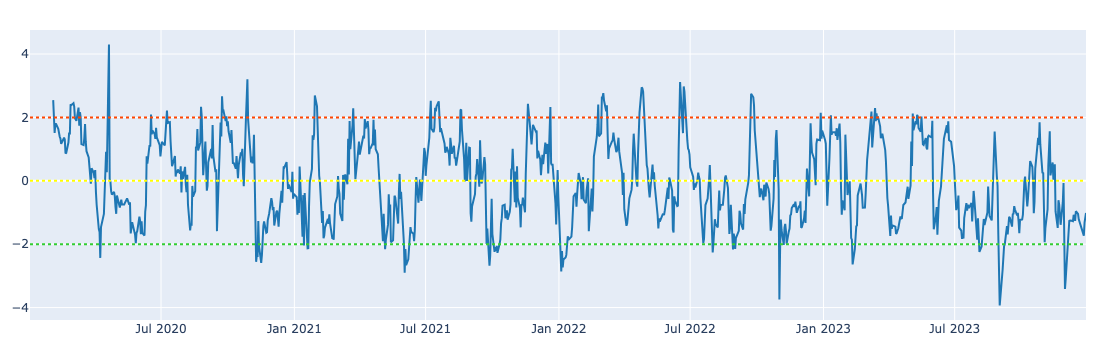

In [24]:
fig = zscore.vbt.plot()
fig.add_hline(y=thresh, line_color="orangered", line_dash="dot")
fig.add_hline(y=0, line_color="yellow", line_dash="dot")
fig.add_hline(y=-thresh, line_color="limegreen", line_dash="dot")
fig.show()

Adding reference lines is important because it makes entry and exit levels visually explicit. Traders can immediately see when the z-score crosses meaningful thresholds, confirming where signals are triggered. This type of annotated chart is a practical tool for validating whether the strategy logic aligns with actual market behavior.

# Run the backtest and analyze the results

This code builds a backtest portfolio object called `perf` using Vectorbt’s `Portfolio.from_signals` method. It simulates trades on Phillips 66 (`psx`) by going long when the z-score triggers an entry and exiting when the z-score triggers an exit, with a daily frequency (`1D`).

In [27]:
pf = vbt.Portfolio.from_signals(
    psx,
    entries=long_entries,
    exits=long_exits,
    freq="1D"
)

Constructing a portfolio object is the step where trading logic becomes measurable performance. It converts raw signals into executed trades, applying realistic entry and exit rules. This allows you to analyze returns, drawdowns, and risk metrics in a structured way, which is essential for validating and refining algorithmic trading strategies.  

This code calls `perf.stats()`, which generates a full statistical summary of the backtested portfolio stored in `perf`. The output includes key performance metrics such as total return, annualized return, Sharpe ratio, maximum drawdown, win rate, and more.

In [28]:
pf.stats()

Start                         2020-01-02 05:00:00+00:00
End                           2023-12-29 05:00:00+00:00
Period                               1006 days 00:00:00
Start Value                                       100.0
End Value                                    114.539327
Total Return [%]                              14.539327
Benchmark Return [%]                          41.864791
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              28.862336
Max Drawdown Duration                 472 days 00:00:00
Total Trades                                          9
Total Closed Trades                                   8
Total Open Trades                                     1
Open Trade PnL                                21.290506
Win Rate [%]                                       25.0
Best Trade [%]                                20.734048
Worst Trade [%]                              -12

Running `perf.stats()` is essential because it translates raw trades into quantifiable results. These statistics allow you to objectively measure the profitability and risk profile of the strategy. They form the basis for comparing different strategies, tuning parameters, and deciding whether a system is robust enough for live deployment.  

This code calls `pf.plot().show()`, which generates a performance plot of the backtested portfolio. The `.show()` command then renders the interactive chart. 

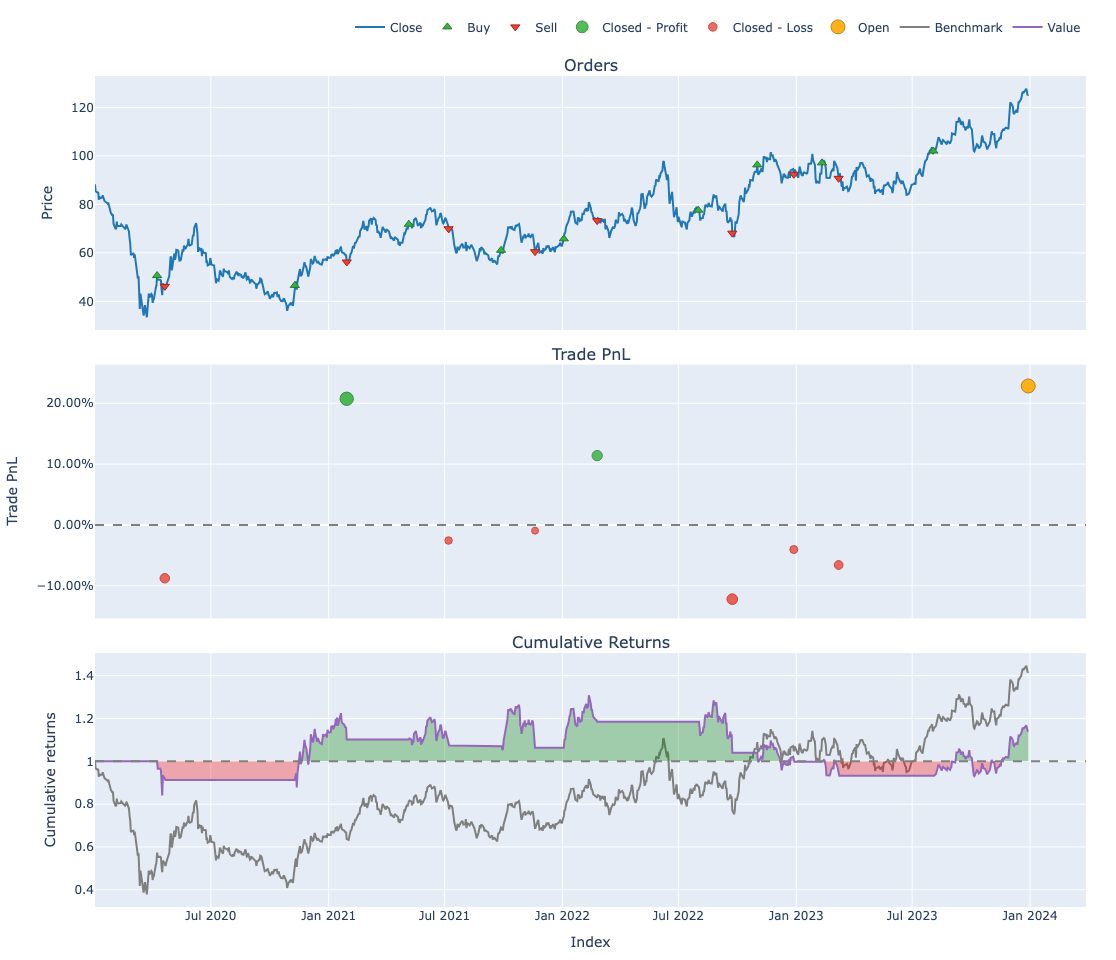

In [30]:
pf.plot().show()

Disabling benchmark returns focuses the visualization purely on the strategy’s performance. This is useful when you want to isolate how the system behaves on its own without comparing it to a market index. Visual performance analysis like this highlights drawdowns, equity curve behavior, and volatility patterns—critical inputs for deciding whether a strategy is stable and tradeable.

# Optimize the input parameter

Optimize risk management, including stop loss levels, position sizing, and take-profit levels. Optimize timing parameters, such as signal thresholds and timeframes. Do not optimize complex combinations, like using 19 technical indicators. Avoid non-economic parameters, such as a 243 moving average. Do not optimize static parameters that don’t adapt to changing markets.

This function `test_strat` runs a parameterized version of the strategy and reports its key metrics. It generates long entry and exit signals using z-score thresholds (`entry_th` and `exit_th`), builds a backtest portfolio on `psx` prices, and returns summary statistics: total return, number of trades, win rate, and expectancy. 

In [41]:
def test_strat(entry_th, exit_th):
    
    long_entries = zscore.vbt.crossed_below(-entry_th)
    long_exits = zscore.vbt.crossed_above(exit_th)

    pf = vbt.Portfolio.from_signals(
        close=psx,
        entries=long_entries,
        exits=long_exits,
        freq="1D",
    )

    return pf.stats(["total_return", "total_trades", "win_rate", "expectancy"])

Wrapping strategy logic in a function is important because it allows systematic testing across different parameter values. This enables you to evaluate robustness, optimize thresholds, and identify the conditions where the strategy performs best. Parameterized backtests like this are the foundation for research workflows in algorithmic trading.

This code creates two lists of threshold values, `entry_th` and `exit_th`, ranging from 0.1 to 3.5 in increments of 0.1. It then generates all possible combinations of these thresholds using `product`, storing them in `th_combs`. 

In [42]:
entry_th = [i / 10 for i in range(1, 36)]
exit_th = [i / 10 for i in range(1, 36)]
th_combs = list(product(entry_th, exit_th))

Generating combinations of entry and exit thresholds is a key step in systematic parameter testing. It allows you to run the strategy across a grid of possible values to identify which parameter sets produce the most robust performance. This type of structured experimentation forms the basis of optimization and robustness analysis in algorithmic trading.

This code benchmarks the performance of the parameterized strategy across all threshold combinations. It records the start time, runs `test_strat` for each `(entry_th, exit_th)` pair in `th_combs`, stores the results in `comb_stats`, and finally prints how many simulations were completed and how long it took. 

In [47]:
start_time = time.time()
comb_stats = [
    test_strat(entry_th=entry_th, exit_th=exit_th) 
    for entry_th, exit_th 
    in th_combs
]
total = int(time.time() - start_time)
print(f"Ran {len(th_combs)} simulations in ~{total} seconds or {round(total/len(th_combs), 4)} seconds per run")

Ran 1225 simulations in ~10 seconds or 0.0082 seconds per run


Batch simulation like this is critical for parameter optimization in algorithmic trading. It allows you to systematically evaluate strategy performance across a grid of inputs and measure robustness. Timing the run also highlights computational efficiency, which becomes increasingly important when testing larger parameter spaces or higher-frequency data.

This code converts the list of simulation results `comb_stats` into a pandas DataFrame called `comb_stats_df`. It then sets a hierarchical index using `pd.MultiIndex.from_tuples`, with `entry_th` and `exit_th` as the index levels, making results easy to slice and analyze by parameter combination.

In [48]:
comb_stats_df = pd.DataFrame(comb_stats)
comb_stats_df.index = pd.MultiIndex.from_tuples(
    th_combs, 
    names=["entry_th", "exit_th"]
)

Storing simulation results in a structured DataFrame is critical for parameter optimization. A MultiIndex allows you to efficiently query and visualize performance across entry and exit thresholds. This organization makes it straightforward to identify robust parameter regions, compare strategies, and generate heatmaps or surface plots for deeper analysis.

This code generates a heatmap of total returns across all entry and exit threshold combinations. It uses Vectorbt’s `vbt.heatmap()` function on the `"Total Return [%]"` column of the results DataFrame and displays the interactive plot.

In [40]:
comb_stats_df["Total Return [%]"].vbt.heatmap().show()

Heatmaps are powerful tools in strategy research because they reveal how performance varies across parameter spaces. By visualizing returns over entry and exit thresholds, traders can quickly identify stable, profitable regions and avoid parameter sets that are fragile. This kind of robustness testing ensures that a strategy’s success is not dependent on a single, overly-optimized setting.

**Resources**:

* [Past issues of the PyQuant Newsletter](https://pyquantnews.com/the-pyquant-newsletter/past-issues/)
* [Getting Started With Python for Quant Finance](https://www.pyquantnews.com/getting-started-with-python-for-quant-finance)